In [ ]:
!nvidia-smi

Sun Feb 14 15:34:51 2021       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 460.39       Driver Version: 460.32.03    CUDA Version: 11.2     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  Tesla T4            Off  | 00000000:00:04.0 Off |                    0 |
| N/A   42C    P8    10W /  70W |      0MiB / 15109MiB |      0%      Default |
|                               |                      |                  N/A |
+-------------------------------+----------------------+----------------------+
                                                                               
+-------

In [ ]:
import pandas as pd
import numpy as np
import keras
import glob
import matplotlib.pyplot as plt
import scipy
import seaborn as sns
from mlxtend.preprocessing import minmax_scaling
from sklearn.metrics import roc_curve, auc

from keras.utils.np_utils import to_categorical
from keras.models import Sequential, Model, load_model
from keras.layers import Dense, Dropout, Flatten, Conv2D, MaxPool2D, GlobalAveragePooling2D, Input, BatchNormalization, Multiply, Activation
from keras.optimizers import RMSprop, SGD
from keras.regularizers import l2
from tensorflow.keras.preprocessing import image
from keras.preprocessing.image import ImageDataGenerator,load_img
from keras.utils import plot_model
from keras.callbacks import ReduceLROnPlateau, ModelCheckpoint, EarlyStopping
from sklearn.metrics import accuracy_score
from sklearn.metrics import confusion_matrix
from keras import backend as K
from tensorflow.keras.applications.mobilenet import MobileNet

import os

Find file paths and number of train and test photos for each class

In [ ]:
# find file paths
food = ['apple_pie','baby_back_ribs', 'baklava', 'pizza', 'soup'] 
f_train_path = '/content/drive/MyDrive/Colab Projects/food_5classes150Photos/train/'
f_test_path = '/content/drive/MyDrive/Colab Projects/food_5classes150Photos/test/'
f_apple = glob.glob(f_train_path + food[0]+'/*')
f_baby = glob.glob(f_train_path + food[1]+'/*')
f_baklava = glob.glob(f_train_path + food[2]+'/*')
f_pizza = glob.glob(f_train_path + food[3]+'/*')
f_soup = glob.glob(f_train_path + food[4]+'/*')

f_apple_test = glob.glob(f_test_path + food[0]+'/*')
f_baby_test = glob.glob(f_test_path + food[1]+'/*')
f_baklava_test = glob.glob(f_test_path + food[2]+'/*')
f_pizza_test = glob.glob(f_test_path + food[3]+'/*')
f_soup_test = glob.glob(f_test_path + food[4]+'/*')
# total train and test files for each category
print('Number of images per class:\n\t\ttrain\ttest \nApple_pie:\t{}\t{}\nBaby_pork_ribs:\t{}\t{}\nBaklava:\t{}\t{}\nPizza:\t\t{}\t{}\nSoup:\t\t{}\t{}'
      .format(len(f_apple),len(f_apple_test),len(f_baby),len(f_baby_test),len(f_baklava),len(f_baklava_test),len(f_pizza),len(f_pizza_test),len(f_soup),len(f_soup_test)))

Number of images per class:
		train	test 
Apple_pie:	150	30
Baby_pork_ribs:	150	30
Baklava:	150	30
Pizza:		150	30
Soup:		150	30


Preview unprocessed images

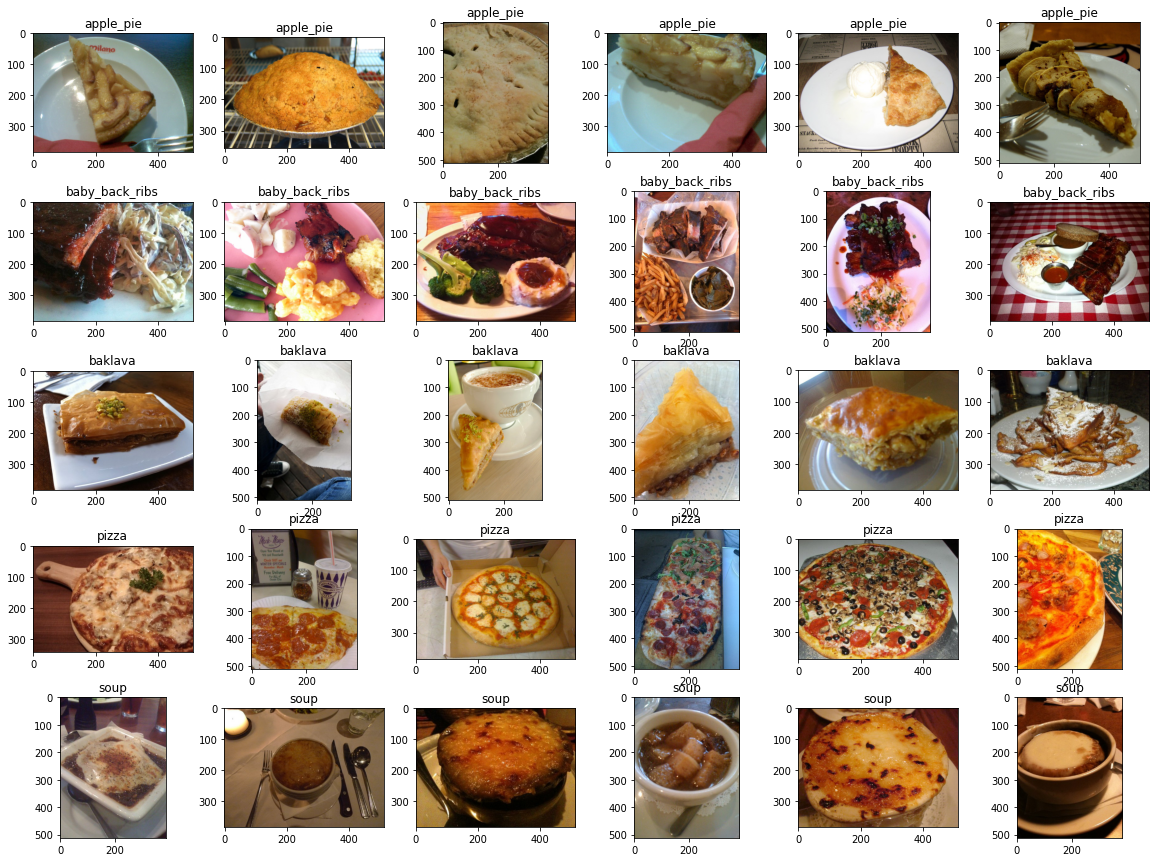

In [ ]:
# preview some images of each class
classes = ['apple_pie','baby_back_ribs', 'baklava', 'pizza', 'soup'] 
food_list = [f_apple, f_baby, f_baklava, f_pizza, f_soup]
n = 6
from glob import glob
classes_number = len(classes)
fig, axes = plt.subplots(classes_number,n,figsize=(20,15))

for i in range(classes_number):
  for j in range(n):
    axes[i, j].imshow(plt.imread(food_list[i][j]))
    axes[i, j].set_title(classes[i])

The images are of different sizes and aspect ratio, with at least one side of 512 pixels.

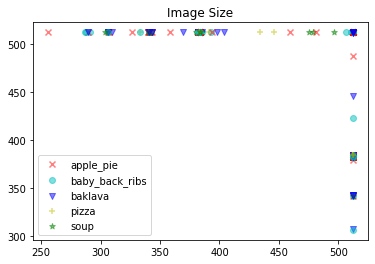

In [ ]:
for i in range(len(f_apple)):
    h1,w1,c1 = plt.imread(f_apple[i]).shape
    h2,w2,c2 = plt.imread(f_baby[i]).shape
    h3,w3,c3 = plt.imread(f_baklava[i]).shape
    h4,w4,c4 = plt.imread(f_pizza[i]).shape
    h5,w5,c5 = plt.imread(f_soup[i]).shape
    plt.scatter(h1,w1,c='r',marker='x',alpha=0.5)
    plt.scatter(h2,w2,c='c',marker='o',alpha=0.5)
    plt.scatter(h3,w3,c='b',marker='v',alpha=0.5)
    plt.scatter(h4,w4,c='y',marker='+',alpha=0.5)
    plt.scatter(h5,w5,c='g',marker='*',alpha=0.5)
plt.title('Image Size')
plt.legend(classes)

**Data Augmentation**

In order to avoid overfitting problem and to expand the dataset. Image data generator from Keras is used for image tranformation.

Expand the dataset so there appear more images that are made out of the initial images, but they are slightly rotated, flipped, etc

In [ ]:
train_datagen = ImageDataGenerator(featurewise_center=False,
                 samplewise_center=False,
                 featurewise_std_normalization=False,
                 samplewise_std_normalization=False,
                 zca_whitening=False,
                 rotation_range=5, #randomly rotate images in the range(degrees, 0 to 180)
                 width_shift_range=0.05, #randomly shift images horizontally (fraction of total width)
                 height_shift_range=0.05, ##randomly shift images vertically (fraction of total height)
                 shear_range=0.2,
                 zoom_range=0.2,
                 channel_shift_range=0.,
                 fill_mode='nearest',
                 cval=0.,
                 horizontal_flip=True,
                 vertical_flip=False,
                 rescale=1/255) #normalize image, add zoom range of 0.2x and horizontal flip
train_generator = train_datagen.flow_from_directory( #images are loaded progressively in alphabetical order and assigned an integer for each class 
        f_train_path,
        target_size=(224,224),
        batch_size=16)
test_datagen = ImageDataGenerator(rescale=1/255) # just normalize for testing set
test_generator = test_datagen.flow_from_directory(
        f_test_path,
        target_size=(224,224),
        batch_size=16)

Found 750 images belonging to 5 classes.
Found 150 images belonging to 5 classes.


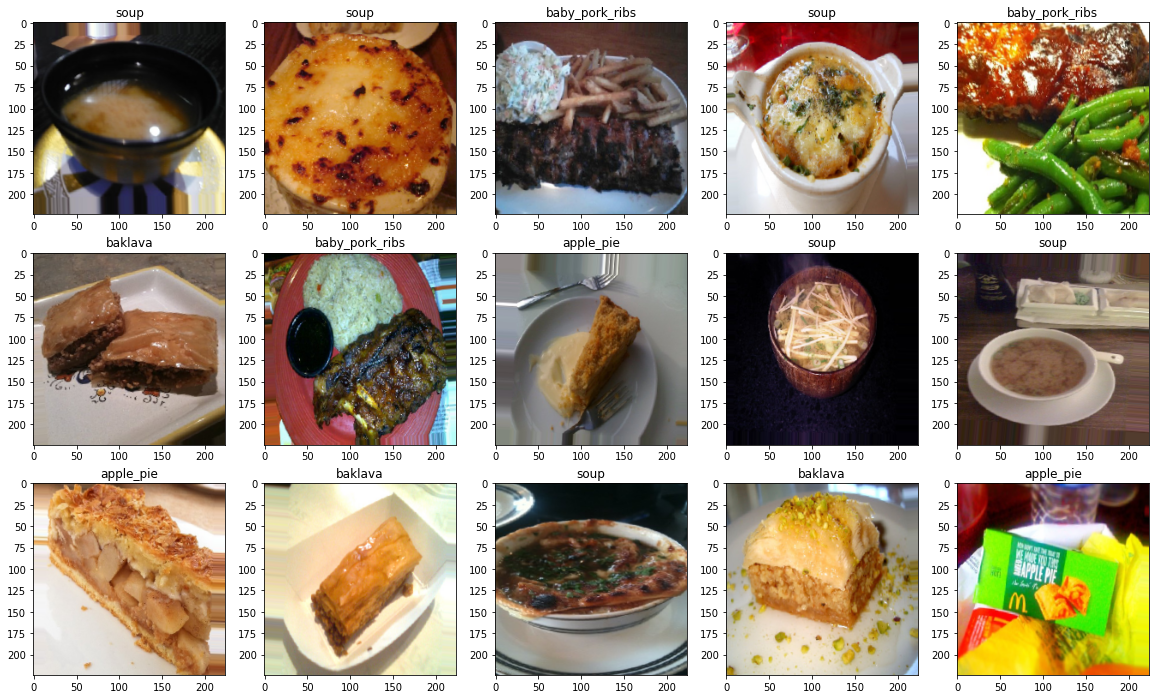

In [ ]:
# preview images from train generator
r = 3; c = 5
n=0
classtolabel = {'0':'apple_pie','1':'baby_pork_ribs','2':'baklava', '3':'pizza', '4':'soup'} #alphabetical order, each class assigned an integer because of flow_from_directory() function
for x in train_generator:
    fig, axes = plt.subplots(r,c,figsize=(20,12))
    for i in range(r):
        for j in range(c):
            axes[i,j].imshow(x[0][n])
            label = np.argmax(x[1],axis=1)[n].astype('str')
            axes[i,j].set_title(classtolabel[label])
            n+=1    
    break

Modelling

Transfer Learning from MobileNet Keras model

In [ ]:
nclass = len(train_generator.class_indices)
base_model = MobileNet(weights='imagenet', 
                                include_top=False, 
                                input_shape=(224, 224,3))
base_model.trainable = False
base_model.summary()

17227776/17225924 [==============================] - 0s 0us/step
Model: "mobilenet_1.00_224"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         [(None, 224, 224, 3)]     0         
_________________________________________________________________
conv1 (Conv2D)               (None, 112, 112, 32)      864       
_________________________________________________________________
conv1_bn (BatchNormalization (None, 112, 112, 32)      128       
_________________________________________________________________
conv1_relu (ReLU)            (None, 112, 112, 32)      0         
_________________________________________________________________
conv_dw_1 (DepthwiseConv2D)  (None, 112, 112, 32)      288       
_________________________________________________________________
conv_dw_1_bn (BatchNormaliza (None, 112, 112, 32)      128       
_________________________________________________

In [ ]:
model = Sequential([
  base_model,
  GlobalAveragePooling2D(),
  Dropout(0.2),#dropout 20% of data to avoid memorization 
  Dense(nclass, activation = "softmax",kernel_initializer='he_normal',kernel_regularizer=l2())])

model.summary()

Model: "sequential_3"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
mobilenet_1.00_224 (Function (None, 7, 7, 1024)        3228864   
_________________________________________________________________
global_average_pooling2d (Gl (None, 1024)              0         
_________________________________________________________________
dropout (Dropout)            (None, 1024)              0         
_________________________________________________________________
dense_3 (Dense)              (None, 5)                 5125      
Total params: 3,233,989
Trainable params: 5,125
Non-trainable params: 3,228,864
_________________________________________________________________


In [ ]:
#callbacks
checkpointer = ModelCheckpoint(filepath='modelMobileNet.hdf5', verbose=1, save_best_only=True, save_weights_only=True)
earlystopping = EarlyStopping(monitor='val_loss', min_delta=0.01, patience=20, mode='auto')
reduceLR = ReduceLROnPlateau(monitor='val_loss', factor=0.5, patience=10, mode='auto')

model.compile(optimizer = 'Adam' , loss = "categorical_crossentropy", metrics=["accuracy"])

In [ ]:
train_photos = 750
test_photos = 150
batch_size = 16
history = model.fit_generator(train_generator,steps_per_epoch=train_photos/batch_size,
                              validation_data=test_generator,validation_steps=test_photos/batch_size, 
                              epochs=50, callbacks=[checkpointer, reduceLR, earlystopping])

/usr/local/lib/python3.6/dist-packages/tensorflow/python/keras/engine/training.py:1844: UserWarning: `Model.fit_generator` is deprecated and will be removed in a future version. Please use `Model.fit`, which supports generators.
  warnings.warn('`Model.fit_generator` is deprecated and '


Epoch 1/50
46/46 [==============================] - 13s 250ms/step - loss: 1.8451 - accuracy: 0.3268 - val_loss: 0.9794 - val_accuracy: 0.6667

Epoch 00001: val_loss improved from inf to 0.97937, saving model to modelMobileNet.hdf5
Epoch 2/50
46/46 [==============================] - 11s 243ms/step - loss: 0.9897 - accuracy: 0.6496 - val_loss: 0.7169 - val_accuracy: 0.7600

Epoch 00002: val_loss improved from 0.97937 to 0.71689, saving model to modelMobileNet.hdf5
Epoch 3/50
46/46 [==============================] - 11s 240ms/step - loss: 0.7245 - accuracy: 0.7582 - val_loss: 0.6258 - val_accuracy: 0.8400

Epoch 00003: val_loss improved from 0.71689 to 0.62576, saving model to modelMobileNet.hdf5
Epoch 4/50
46/46 [==============================] - 11s 239ms/step - loss: 0.6229 - accuracy: 0.8191 - val_loss: 0.5779 - val_accuracy: 0.8600

Epoch 00004: val_loss improved from 0.62576 to 0.57787, saving model to modelMobileNet.hdf5
Epoch 5/50
46/46 [==============================] - 11s 244m

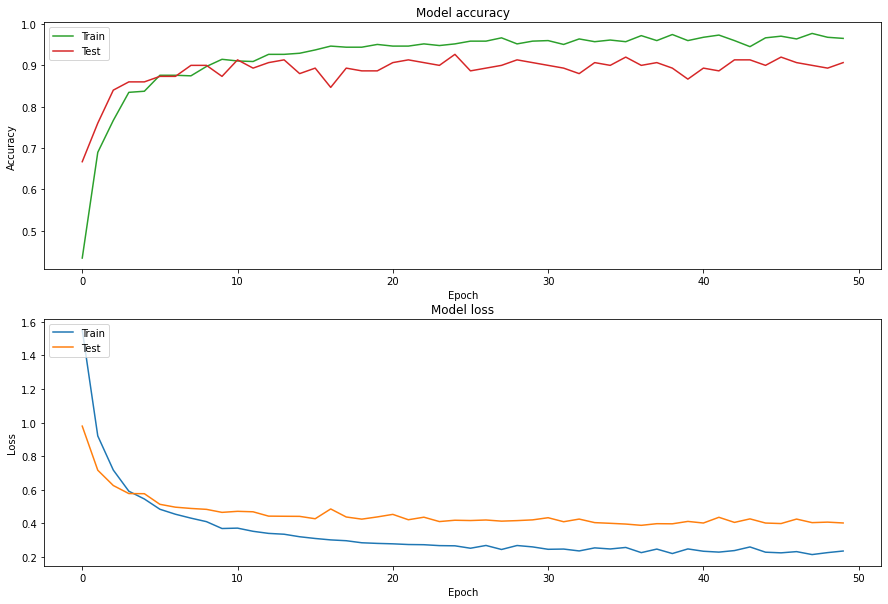

In [ ]:
def plot_hist(history):
    f,ax = plt.subplots(2,1,figsize=(15,10))
    ax[0].plot(history.history['accuracy'],c='C2')
    ax[0].plot(history.history['val_accuracy'],c='C3')
    ax[0].set_title('Model accuracy')
    ax[0].set_ylabel('Accuracy')
    ax[0].set_xlabel('Epoch')
    ax[0].legend(['Train', 'Test'], loc='upper left')
    
    # summarize history for loss
    ax[1].plot(history.history['loss'],c='C0')
    ax[1].plot(history.history['val_loss'],c='C1')
    ax[1].set_title('Model loss')
    ax[1].set_ylabel('Loss')
    ax[1].set_xlabel('Epoch')
    ax[1].legend(['Train', 'Test'], loc='upper left')
    
plot_hist(history)

**Evaluate results**

In [ ]:
# create another generator for all test images in a single batch (150 photos total in test)
val_datagen = ImageDataGenerator(rescale=1./255)
val_generator = val_datagen.flow_from_directory(
        f_test_path,
        target_size=(224,224),
        batch_size=150)

Found 150 images belonging to 5 classes.


**Prediction**

*Load trained model (optional)*

In [ ]:
export_path_keras = "/content/drive/MyDrive/Colab Projects/model2-MobileNet.h5"
model = load_model(export_path_keras)

model.summary()

Model: "sequential_3"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
mobilenet_1.00_224 (Function (None, 7, 7, 1024)        3228864   
_________________________________________________________________
global_average_pooling2d (Gl (None, 1024)              0         
_________________________________________________________________
dropout (Dropout)            (None, 1024)              0         
_________________________________________________________________
dense_3 (Dense)              (None, 5)                 5125      
Total params: 3,233,989
Trainable params: 5,125
Non-trainable params: 3,228,864
_________________________________________________________________


In [ ]:
x_test, y_test = val_generator.next()
y_pred_conf = model.predict(x_test) #return probabilities of each class
y_pred = np.argmax(y_pred_conf,axis=1)
y_label = np.argmax(y_test,axis=1)

print('Accuracy score: {:.1f}%'.format(accuracy_score(y_pred,y_label)*100))

Accuracy score: 90.7%


Randomly check 10 predictions

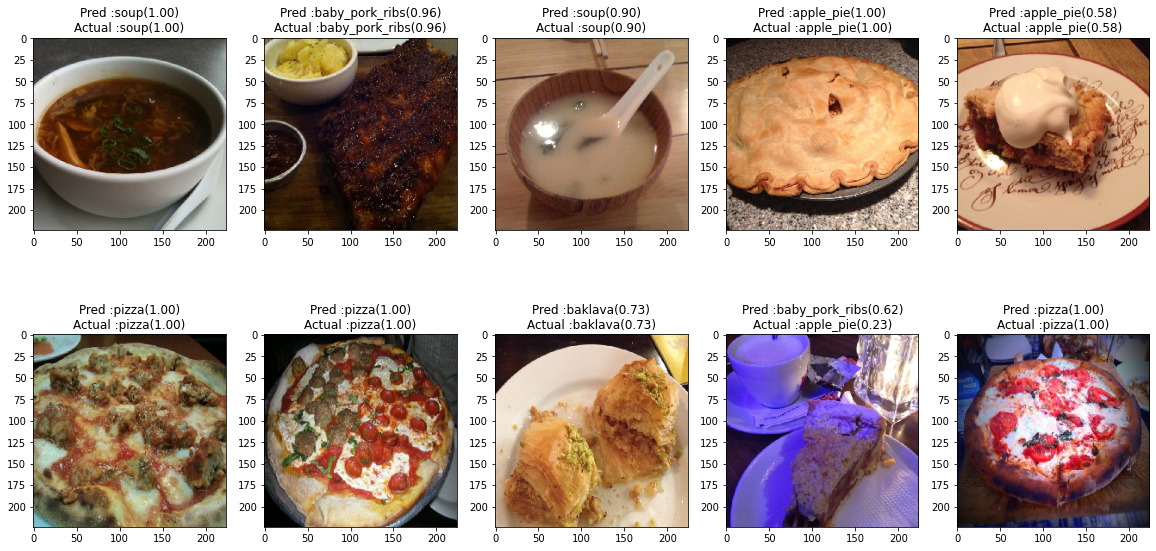

In [ ]:
#ind = np.random.randint(1,len(x_test),10)
f, ax=plt.subplots(2,5,figsize=(20,10))
for k in range(2):
  for l in range(5):
      j=np.random.randint(1,len(x_test))
      ax[k,l].imshow(x_test[j])
      ax[k,l].set_title("Pred :{}({:.2f})\nActual :{}({:.2f})".format
                            (classtolabel[str(y_pred[j])],np.max(y_pred_conf[j]),
                            classtolabel[str(y_label[j])],y_pred_conf[j][(y_label[j])],fontweight="bold", size=20))

**Confusion Matrix**

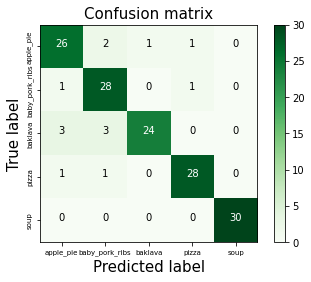

In [ ]:
def plot_confusion_matrix(cm):    
    plt.imshow(cm, interpolation='nearest', cmap=plt.cm.Greens)
    plt.title('Confusion matrix',fontsize=15)
    plt.colorbar()
    classes = ['apple_pie','baby_pork_ribs','baklava','pizza','soup']
    plt.xticks([0,1,2,3,4], classes, fontsize=7)
    plt.yticks([0,1,2,3,4], classes, fontsize=7,rotation=90,verticalalignment="center")
    for i in range(cm.shape[0]):
        for j in range(cm.shape[1]):
            plt.text(j, i, format(cm[i, j], 'd'), horizontalalignment="center", color="white" if cm[i, j] > np.max(cm)/2. else "black")
    plt.xlabel('Predicted label',fontsize=15)
    plt.ylabel('True label',fontsize=15)
    
plot_confusion_matrix(confusion_matrix(y_label,y_pred))

Inspect the predictions with wrong labels

In [ ]:
# find the wrong-est label (largest confidence wrong label)
def show_wrongest_label(x_test,y_test,y_pred_conf):
    y_pred = np.argmax(y_pred_conf,axis=1) # convert predictions to labels
    y_label = np.argmax(y_test,axis=1) # convert answer to labels

    errors = (y_pred - y_label != 0) # find booleans of wrong predictions
    y_pred_errors = y_pred_conf[errors] #the probabilities of the wrong Y_pred [0.5,0.2,0.3]

    y_pred_classes_errors = y_pred[errors] # the wrong pred label [2]
    y_pred_errors_prob = np.max(y_pred_errors,axis = 1) # Probabilities of the wrong predicted numbers [0.5]

    y_true_classes_errors = y_label[errors] # the true label [0]
    y_true_errors_prob = np.diagonal(np.take(y_pred_errors, y_true_classes_errors, axis=1)) # Predicted prob of the true values in the error set[0.2]

    img_errors = x_test[errors] # image of each errors

    # Difference between the probability of the predicted label and the true label
    delta_pred_true_errors = y_pred_errors_prob - y_true_errors_prob
    # Get index of delta prob errors in ascending order
    sorted_delta_errors = np.argsort(delta_pred_true_errors)
    # The index of top 15 errors 
    most_important_errors = sorted_delta_errors[-15:]
    
    
    def display_errors(errors_index,img_errors,pred_errors, obs_errors):
        n = 0
        nrows = 3
        ncols = 4
        fig, ax = plt.subplots(nrows,ncols,sharex=True,sharey=True)
        fig.set_figheight(20)
        fig.set_figwidth(30)
        for row in range(nrows):
            for col in range(ncols):
                error = errors_index[n]
                ax[row,col].imshow((img_errors[error]))
                ax[row,col].set_title("Pred :{}({:.2f})\nActual :{}({:.2f})".format
                                      (classtolabel[pred_errors[error].astype('str')],y_pred_errors_prob[error],
                                       classtolabel[obs_errors[error].astype('str')],y_true_errors_prob[error]),
                                      fontweight="bold", size=20)
                n += 1
    
    display_errors(most_important_errors, img_errors, y_pred_classes_errors, y_true_classes_errors)

In [ ]:
show_wrongest_label(x_test,y_test,y_pred_conf)

Output hidden; open in https://colab.research.google.com to view.

Save model as keras .h5 model

I save the model as an HDF5 file, which is the format used by Keras. The HDF5 file will have the extension '.h5'

In [ ]:
export_path_keras = "/content/drive/MyDrive/Colab Projects/model2-MobileNet.h5"
print(export_path_keras)

model.save(export_path_keras)

/content/drive/MyDrive/Colab Projects/model2-MobileNet.h5


Load model as keras model

In [ ]:
export_path_keras = "/content/drive/MyDrive/Colab Projects/model2-MobileNet.h5"
reloaded = load_model(export_path_keras)

reloaded.summary()

Model: "sequential_3"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
mobilenet_1.00_224 (Function (None, 7, 7, 1024)        3228864   
_________________________________________________________________
global_average_pooling2d (Gl (None, 1024)              0         
_________________________________________________________________
dropout (Dropout)            (None, 1024)              0         
_________________________________________________________________
dense_3 (Dense)              (None, 5)                 5125      
Total params: 3,233,989
Trainable params: 5,125
Non-trainable params: 3,228,864
_________________________________________________________________


Predict single image

array([[0.11225841, 0.250634  , 0.30255294, 0.33182177, 0.00273286]],
      dtype=float32)

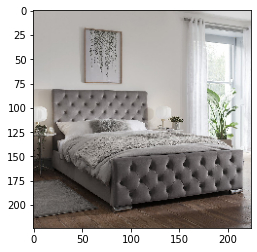

In [ ]:
img=load_img('/content/drive/MyDrive/Colab Projects/food_3classes100Photos/bed.jpg',target_size=(224,224))
plt.imshow(img)
img = np.array(img).astype('float32')/255
img = np.expand_dims(img, axis=0)
reloaded.predict(img)

In [ ]:
#make a threshold such that, only if the model is at least 40% sure that the object is food, then food exists in the picture
classtolabel = {'0':'apple_pie','1':'baby_pork_ribs','2':'baklava','3':'pizza','4':'soup'}
result = reloaded.predict(img)
maximum = np.max(result)
y_pred = np.argmax(result,axis=1)
if maximum >= 0.4: #apply threshold of 40% 
  print(classtolabel[str(y_pred[0])])
else:
  print('the model is not sure if there is even food in the picture')

the model is not sure if there is even food in the picture
